In [2]:
import cPickle as pkl
from cspython.scraper import modifiedSoup
from cspython.data_processing import process_scrapped
import cPickle as pkl
import sys
sys.setrecursionlimit(15000)

import cspython.analysis as a
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib


import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
#import sklearn
#print('sklearn: {}'.format(sklearn.__version__))
#import xlrd

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline


import sklearn
print('sklearn: {}'.format(sklearn.__version__))
#import xlrd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
#import xgboost as xgb
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation #might be model_selection <--- this is the new one
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn import preprocessing 
sns.set_style("whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

scipy: 0.19.0
numpy: 1.11.3
matplotlib: 2.0.2
pandas: 0.18.1
sklearn: 0.18.1


C:\Users\SuperBug\Anaconda2\envs\cs_project\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
with open('../scrapped_data/Fixed_Data/BIG_2016-10-01_to_2017-10-13.pkl', 'rb') as f: 
     d = pkl.load(f)

In [4]:
big_data = process_scrapped(d)
overview, big_data = big_data

In [5]:
def combine_dfs(big_data):
    for l in range(len(big_data.keys())):
        series_data = big_data[big_data.keys()[l]]
        series_data_m = merge_matches(series_data)
        series_data_mo = merge_overview(series_data_m, series_data)
        series_data_mos = merge_scoreboards(series_data_mo, series_data)
        if l == 0:
            data = series_data_mos
        else:
            data = pd.concat([data, series_data_mos])
    return data

In [6]:
def merge_matches(series_data):
    for d in range(0,len(series_data['matches'])):
        if d == 0:
            series_data['matches'][d] = series_data['matches'][d].rename(index = str, columns={ series_data['matches'][d].columns[10] : "team_A", series_data['matches'][d].columns[11] : "team_B" })
            series_data_m = series_data['matches'][d]
        else:
            series_data['matches'][d] = series_data['matches'][d].rename(index = str, columns={ series_data['matches'][d].columns[10] : "team_A", series_data['matches'][d].columns[11] : "team_B" })
            series_data_m = pd.concat([series_data_m, series_data['matches'][d]])
    return series_data_m
    #should work for concact the matches together


In [7]:
def merge_overview(series_data_m, series_data):
    series_data['match_overview'] = series_data['match_overview'].rename(index = str, columns ={series_data['match_overview'].columns[4]: "team_A_score",series_data['match_overview'].columns[5]: "team_B_score"})
    series_data_mo = pd.merge(series_data_m, series_data['match_overview'], on=['match_id', 'winner', 'map', 'series_id'])
    return series_data_mo
#works at merging matches with match_overviewb

In [8]:
def merge_scoreboards(series_data_mo, series_data):    
    for i in range(len(series_data['scoreboards'][0])):
        series_data['scoreboards'][0][i]['match_num'] = i+1
        series_data['scoreboards'][0][i] = series_data['scoreboards'][0][i].rename(index = str, columns={ series_data['scoreboards'][0][i].columns[0] : "team_players" })
        series_data['scoreboards'][1][i]['match_num'] = i+1
        series_data['scoreboards'][1][i] = series_data['scoreboards'][1][i].rename(index = str, columns={ series_data['scoreboards'][1][i].columns[0] : "team_players"})
        new_df = pd.concat([series_data['scoreboards'][0][i], series_data['scoreboards'][1][i]])
        if i == 0:
            con_df = new_df
        else:
            con_df = pd.concat([con_df, new_df])
    series_data_mos = pd.merge(series_data_mo, con_df, how='outer', on='match_num') 
    return series_data_mos

       
        
#works at adding match_num to scoreboards
        
                         

In [9]:
data = combine_dfs(big_data)

In [10]:
data.shape

(28600, 21)

In [11]:
pd.set_option('display.max_columns', None)

In [12]:
data

,map,round_num,half,match_id,series_id,ending,CT,T,side_winner,winner,team_A,team_B,team_A_score,team_B_score,match_num,team_players,K-D,+/-,ADR,KAST,Rating2.0
0,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Fatih 'gob b' Dayik gob b,19-19,0,85.9,64.0%,1.08
1,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Johannes 'nex' Maget nex,21-23,-2,98.0,60.0%,1.06
2,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Johannes 'tabseN' Wodarz tabseN,12-19,-7,66.6,68.0%,0.82
3,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Nikola 'LEGIJA' Ninić LEGIJA,11-16,-5,50.4,64.0%,0.77
4,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Kevin 'keev' Bartholomäus keev,12-19,-7,59.7,56.0%,0.72
5,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Jesse 'zehN' Linjala zehN,21-14,7,86.6,84.0%,1.48
6,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Kevin 'HS' Tarn HS,24-15,9,101.2,68.0%,1.47
7,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Miikka 'suNny' Kemppi suNny,20-14,6,88.4,76.0%,1.28
8,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Kevin 'kRYSTAL' Amend kRYSTAL,17-14,3,61.0,60.0%,0.96
9,Inferno,1,1,3eb1dcd3-c090-4cf5-9362-4b71789d94d7,457c0f97-88c6-41f8-b246-d887b1786f5a,t_win,PENTA,BIG,CT,PENTA,0,1,9,16,1,Paweł 'innocent' Mocek innocent,14-18,-4,73.2,64.0%,0.96


In [13]:
data = pd.concat([data,data['K-D'].str.split('-', 1, expand=True).rename(columns={0:'player_kill', 1:'player_death'})], axis=1)


In [14]:
data.shape

(28600, 23)

In [15]:
data = data.apply(pd.to_numeric, errors='ignore')

In [16]:
data[['map', 'ending', 'CT', 'T', 'side_winner','winner', 'team_players']]= data[['map', 'ending', 'CT', 'T', 'side_winner','winner', 'team_players']].apply(lambda x: pd.factorize(x)[0]) 

In [17]:
data['KAST'] = data['KAST'].apply(lambda x : float(x.strip('%')) / 100.0)

In [18]:
data.dtypes

map               int32
round_num         int64
half              int64
match_id         object
series_id        object
ending            int32
CT                int32
T                 int32
side_winner       int32
winner            int32
team_A            int64
team_B            int64
team_A_score      int64
team_B_score      int64
match_num         int64
team_players      int32
K-D              object
+/-               int64
ADR             float64
KAST            float64
Rating2.0       float64
player_kill       int64
player_death      int64
dtype: object

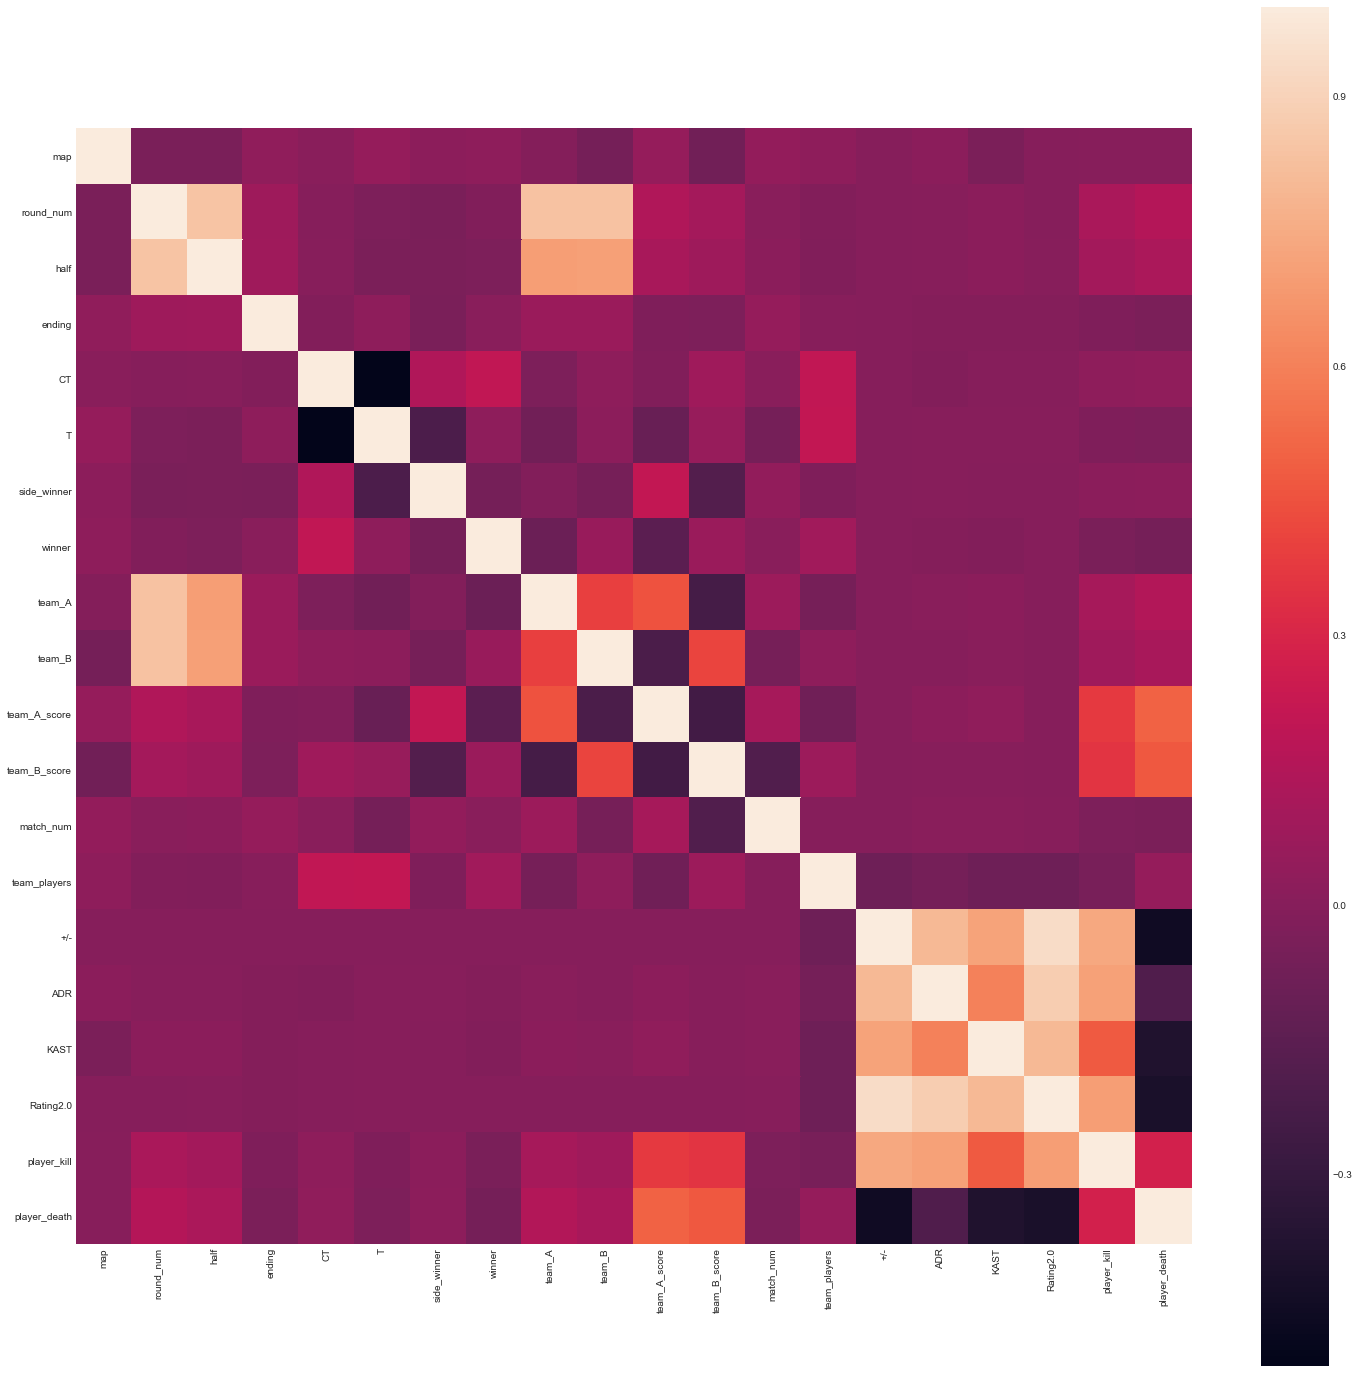

In [19]:
corr = data.select_dtypes(include = ['float64', 'int64', 'int32']).iloc[:, 0:].corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr, vmax=1, square=True)



In [20]:
ydata = data['winner']

In [21]:
data = data.drop('winner', 1)

In [22]:
data = data.drop('match_id', 1)

In [23]:
data = data.drop('series_id', 1)

In [24]:
data = data.drop('K-D', 1)

In [25]:
data.shape

(28600, 19)

In [26]:
y = ydata.values
X = data.values[:,0:19]

In [32]:
num_folds = 10
num_instances = len(X) 
seed = 7
scoring = 'accuracy'

In [33]:
def local_cv(model, params):                             #KFOLD WITH GRID SEARCH
    param_grid = params
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X, y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    for params, mean_score, scores in grid_result.grid_scores_:
        print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

In [ ]:
num_folds = 10
num_instances = len(X) 
seed = 7
scoring = 'accuracy'
model = GradientBoostingClassifier()
params = {
 'max_depth':[4,6,8,10,12,16],
 'n_estimators':[20,30,50,80,100],
'learning_rate':[.1,.01,.001]}
local_cv(model, params)

In [ ]:
models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('NB', GaussianNB()))
#models.append(('CART', DecisionTreeClassifier())) 
#models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
#models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
#models.append(('AdaBoostClassifier', AdaBoostClassifier()))
#models.append(('RandomForestClassifier', RandomForestClassifier()))
#models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('SVC', SVC()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    print '1'
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    print '2'
    cv_results = cross_validation.cross_val_score(model, X, y, cv=kfold, scoring = scoring)
    print '3'
    results.append(cv_results)
    print '4'
    names.append(name)
    print '5'
    model.fit(X, y)
    print '6'
    predicted = model.predict(X)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1
2
3
4
5
6
LR: 0.509895 (0.188490)
1
2
3
4
5
6
LASSO: -0.982929 (1.603916)
1
2
3
4
5
6
Ridge: -1.202563 (2.058277)
1
2
3
4
5
6
LDA: 0.475769 (0.180918)
1
2
3
4
5
6
NB: 0.103601 (0.086233)
1
2
3
4
5
6
CART: 0.414056 (0.154741)
1
2
3
4
5
6
KNeighborsClassifier: 0.512972 (0.119359)
1
2
3
4
5
6
GradientBoostingClassifier: 0.749476 (0.129333)
1
2
3
4
5
6
AdaBoostClassifier: 0.598951 (0.161492)
1
2
3
4
5
6
RandomForestClassifier: 0.625734 (0.142638)
1
2
3
4
5
6
ExtraTreesClassifier: 0.621538 (0.150216)
1
2
3
4
5
6
DecisionTreeClassifier: 0.428881 (0.139885)
1
2
